In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import plotly.plotly as py
import matplotlib
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)


## Import raw data


In [2]:
raw_data = pd.read_csv("Consumer_Coded_Comments_2017_v2.csv", index_col=None)

In [3]:
raw_data.columns

Index([u'Job #', u'Walker ID', u'Walker Respondent ID', u'Question #',
       u'Sentiment', u'L1 Code', u'L2 Code', u'L1 - L2 Code', u'Comment',
       u'Coded Segment', u'Natural Language', u'E-MAIL ADDRESS',
       u'Question Text', u'Month', u'Concatenated Language', u'Qtr', u'Year',
       u'Qtr - Year', u'Month_Year', u'Product Rated', u'Individual NPS Brand',
       u'Individual NPS Product', u'Affiliate ID', u'Customer's Full Name',
       u'Phone', u'Follow-up Contact Flag',
       u'Likelihood to Recommend Brand (11-pt Scale)',
       u'Issue Driving Likelihood to Recommend Brand Rating', u'Committed',
       u'Likelihood to Renew/Buy Again', u'Excellent Reputation',
       u'Preferred Brand', u'Easy to Do Business With', u'Customer Focused',
       u'Trustworthy', u'Purchase/Renewal Process',
       u'Purchase/Renewal Process: Ease of Process',
       u'Purchase/Renewal Process: Clarity of Purchase Information',
       u'Purchase/Renewal Process: Being Easy to Download',
    

In [4]:
raw_data.head(2)

,Job #,Walker ID,Walker Respondent ID,Question #,Sentiment,L1 Code,L2 Code,L1 - L2 Code,Comment,Coded Segment,...,Product Quality,Product: Installation,Product: Usability,Product: Protection Effectiveness,Product: Computer Performance,Product: Being Easy to Update,Product: Stability/Reliability,Product: Features/Functionality,Product: Compatibility,Likelihood to Recommend Product (11-pt Scale)
0,1012220,8741452,467358716,OEQ12_2,Negative,Product,Reliability,Product-Reliability,Have had problems with your product,NaN,...,Very Good,Fair,Good,Fair,Good,Refused,Fair,Very Good,Good,8
1,1012220,8741452,467358716,OEQ50_3,Positive,Product,Sentiment,Product-Sentiment,I find it the best for me,NaN,...,Very Good,Fair,Good,Fair,Good,Refused,Fair,Very Good,Good,8


## TF-IDF based Vectorization

In [5]:
import nltk
import string
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer

token_dict = {}
stemmer = PorterStemmer()
Y = [] # Sensiment labels

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

for i in range(raw_data.shape[0]):
    record = raw_data.iloc[i]
    if not pd.isnull(record.Comment) and not pd.isnull(record.Sentiment):
        lowers = record.Comment.lower()

        no_punctuation = lowers.translate(None, string.punctuation)
        no_punctuation = unicode(no_punctuation, errors='replace')

        token_dict[i] = no_punctuation
        
        # the corresponding y
        Y.append(record.Sentiment)

if not os.path.isfile('TF-IDF.csv'): 
    #this can take some time
    tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english', ngram_range=(1,1))
    tfs = tfidf.fit_transform(token_dict.values())

    df = pd.DataFrame(data=tfs.toarray(), 
                  index = token_dict.keys(), 
                  columns=tfidf.get_feature_names())
    df.to_csv('TF-IDF.csv', encoding='utf-8')
else:
    df = pd.read_csv('TF-IDF.csv')

df_sentiment = pd.DataFrame()
df_sentiment['sentiment'] = Y
df_sentiment.to_csv("Sentiments.csv")

## Word Cloud For Each Product

In [6]:
%matplotlib inline 

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk

convention_words = ['McAfee', 'product', 'computer']

for word in convention_words:
    STOPWORDS.add(word) # add new stop words


def make_word_cloud(product):
    sub_raw_data = raw_data[raw_data['Product Rated'] == product]
    text = " ".join(sub_raw_data.Comment.dropna().tolist())
    text_u = unicode(text, errors='replace')

    for word,pos in nltk.pos_tag(nltk.word_tokenize(text_u)):
        if (pos != 'ADJ' and pos != 'JJ' and pos != 'ADV'):
            word = word.encode('utf-8')
            STOPWORDS.add(word)
    
    # generate a word cloud
    wordcloud = WordCloud(stopwords=STOPWORDS, 
                      background_color='white', 
                      width=1600, 
                      height=800,
                      collocations= True,
                      max_words=300).generate(text)
    plt.figure(figsize=(11,8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [7]:
set(raw_data['Product Rated'])

{'LIVESAFE',
 'MCAFEE ALL ACCESS',
 'MCAFEE INTERNET SECURITY',
 'MCAFEE MOBILE SECURITY',
 'SAFE FAMILY',
 'SECURITY CENTER',
 'TOTAL PROTECTION',
 'TRUE KEY',
 'VIRUSSCAN'}

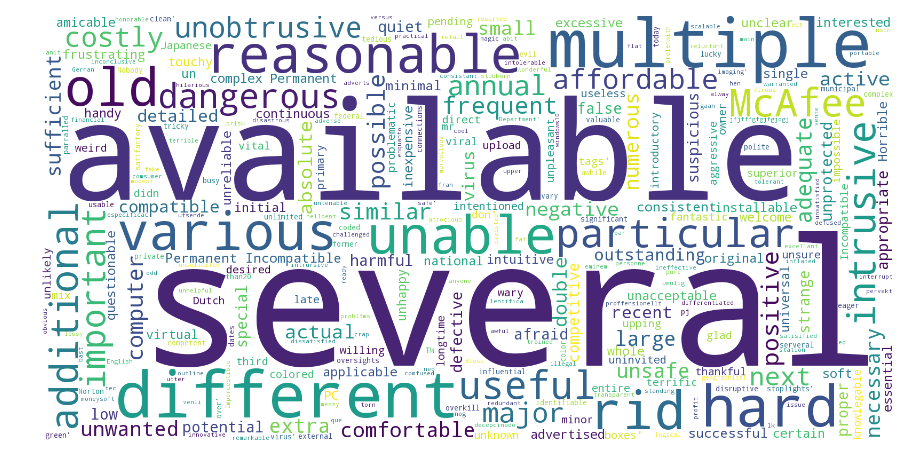

In [8]:
make_word_cloud('LIVESAFE')

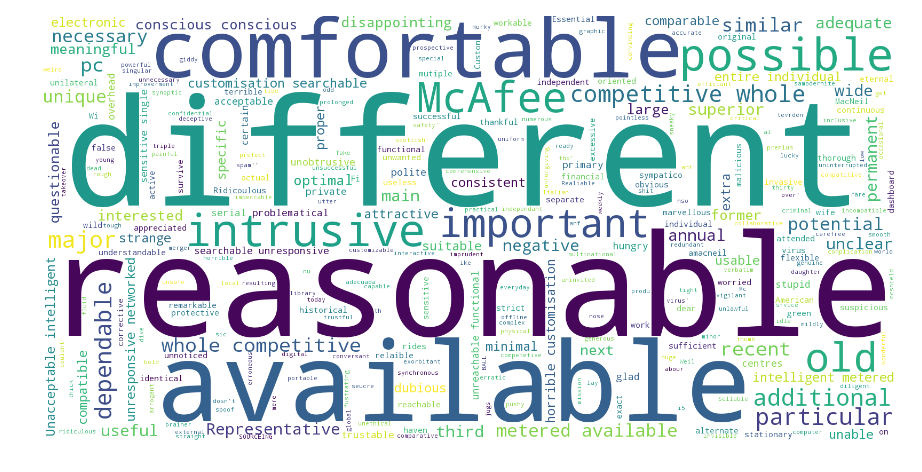

In [9]:
make_word_cloud('MCAFEE ALL ACCESS')

## Performance of Different Classifer

In [10]:
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

def benchmark(clf, data):

    X_train, X_test, Y_train, Y_test = data
    clf.fit(X_train, Y_train)
    pred = clf.predict(X_test)
    precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(
        Y_test, pred, average=None)
    print metrics.classification_report(Y_test, pred)

all_X_array = df.as_matrix()
all_Y_array = Y

data = train_test_split(all_X_array, all_Y_array, test_size=0.2, random_state=10)

clf_knn = KNeighborsClassifier(n_neighbors=10)

clf_MLP = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(100, 2), random_state=1)

clf_rf= RandomForestClassifier(
            n_estimators=100,
            max_depth=None,
            min_samples_split=2,
            random_state=0)

clf_lsvc = LinearSVC()
clf_dt = DecisionTreeClassifier(
            max_depth=None, min_samples_split=6, random_state=0)
clf_adaboost = AdaBoostClassifier(n_estimators=200)

X_train, X_test, Y_train, Y_test = data

print "Training data size:", len(Y_train)
print "Test data size:", len(Y_test)
labels = list(set(Y_test))
print "#of classes:", len(labels)

print('=' * 50)
print("Neural Network-MLP")
benchmark(clf_MLP, data)

print('=' * 50)
print("SVM")
benchmark(clf_lsvc, data)

print('=' * 50)
print("Decision Tree")
benchmark(clf_dt, data)

print('=' * 50)
print("Random Forest")
benchmark(clf_rf, data)

print('=' * 50)
print("AdaBoost")
benchmark(clf_adaboost, data)

Training data size: 20436
Test data size: 5109
#of classes: 5
Neural Network-MLP


/Users/xuq/.virtualenvs/NLP/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



               precision    recall  f1-score   support

     Negative       0.00      0.00      0.00       905
      Neutral       0.00      0.00      0.00       586
Non-Sentiment       0.00      0.00      0.00       415
     Positive       0.63      1.00      0.77      3202
      Unknown       0.00      0.00      0.00         1

  avg / total       0.39      0.63      0.48      5109

SVM
               precision    recall  f1-score   support

     Negative       0.47      0.03      0.06       905
      Neutral       0.25      0.00      0.00       586
Non-Sentiment       0.12      0.00      0.00       415
     Positive       0.66      0.64      0.65      3202
      Unknown       0.00      1.00      0.00         1

  avg / total       0.54      0.41      0.42      5109

Decision Tree
               precision    recall  f1-score   support

     Negative       0.57      0.50      0.53       905
      Neutral       0.48      0.50      0.49       586
Non-Sentiment       0.21      0.17      

KeyboardInterrupt: 